In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
def get_desired_metrics_from_activity_section(actvt_bout_time, data_params):
    time_ons = []
    c_lengths = []

    high_actvt_bout_time = pd.DataFrame()
    for i, col_name in enumerate(data_params["dc_tags"][1:]):
        dc_tag = col_name.split('(')[-1].split(')')[0]
        on = int(dc_tag.split('of')[0])
        total = int(dc_tag.split('of')[-1])
        bin_size = int(data_params['bin_size'])
        dc_actvt = actvt_bout_time[f'bout_time ({col_name})'].copy()
        if i > 0:
            time_ons.append(on)
            c_lengths.append(total)

        recover_ratio = min(total, bin_size) / min(on, bin_size)
        rep_dc_actvt = dc_actvt * recover_ratio

        if total-on >= bin_size:
            high_actvt_bout_time[f'bout_time ({col_name})'] = rep_dc_actvt.replace(np.NaN, -1).replace(0, np.NaN).ffill(limit=(min((14*60)-on, total-on)//bin_size)).replace(np.NaN, 0).replace(-1, np.NaN)
        else:
            high_actvt_bout_time[f'bout_time ({col_name})'] = rep_dc_actvt

    high_actvt_btp = high_actvt_bout_time.copy()
    high_actvt_btp = (high_actvt_btp) * (2 / 1) # #calls per bin * 2 bins per 1 hour to get calls per hour

    exp_dc_btp = high_actvt_btp.iloc[:,1:]
    control_dc_btp = high_actvt_btp.mean()[0]

    metrics = dict()
    metrics['exp_rates'] = exp_dc_btp
    metrics['control_rate'] = control_dc_btp
    metrics['cycle_lengths'] = c_lengths

    return metrics

In [5]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = reset_24
percent_ons = [1/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

Carp 


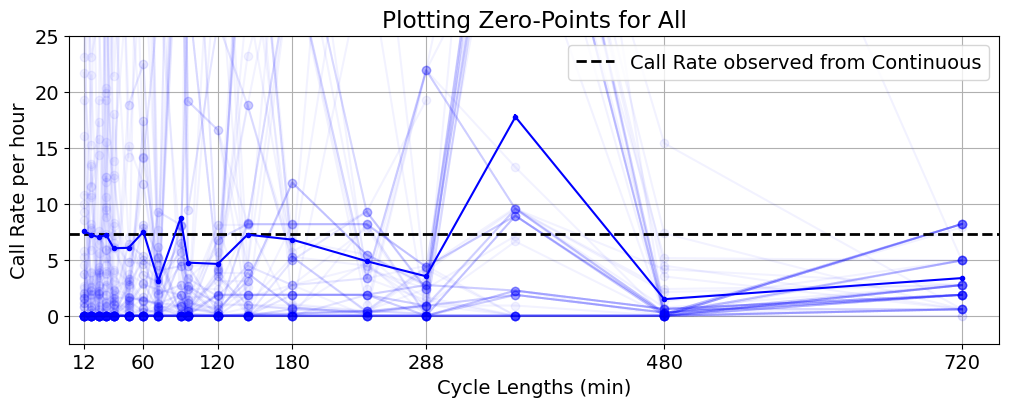

Carp LF


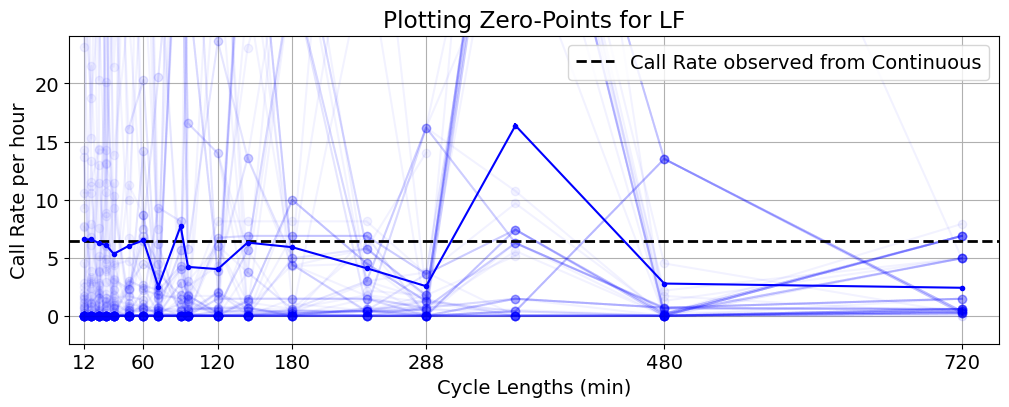

Carp HF


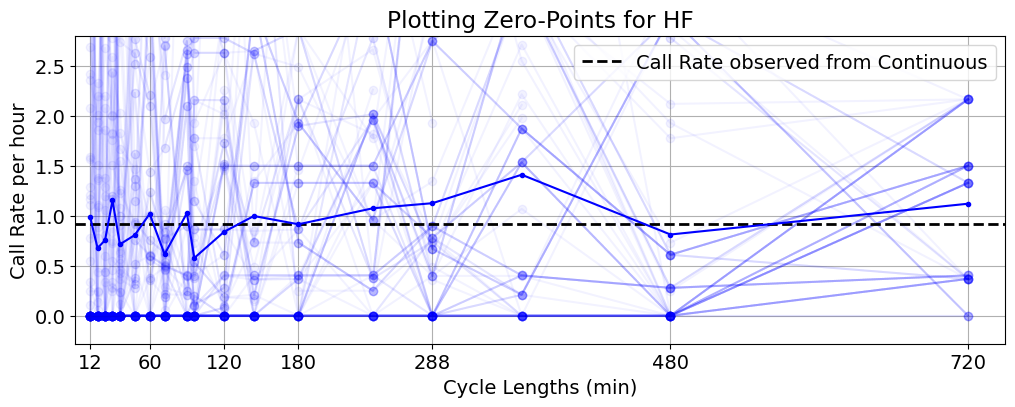

In [6]:
site_key = 'Carp'
type_keys = ['', 'LF', 'HF']
for type_key in type_keys:
    print(site_key, type_key)

    data_params["dc_tags"] = dc_tags
    data_params['cur_dc_tag'] = '30of30'
    data_params["site_name"] = SITE_NAMES[site_key]
    data_params["site_tag"] = site_key
    data_params["type_tag"] = type_key
    data_params['bin_size'] = '30'

    file_paths = get_file_paths(data_params)
    activity_bout_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_bouts_TYPE_SITE_summary"]}.csv', index_col=0)

    activity_bout_arr.index = pd.DatetimeIndex(activity_bout_arr.index)
    actvt_num_calls = activity_bout_arr.loc[dt.datetime(2022, 8, 19, 0, 0, 0):dt.datetime(2022, 8, 21, 16, 0, 0)].copy()

    metrics = get_desired_metrics_from_activity_section(actvt_num_calls, data_params)
    exp_dc_btp = metrics['exp_rates']
    control_dc_btp = metrics['control_rate']
    exp_dc_btp_mean = metrics['exp_rates'].mean()
    exp_dc_btp_ste = metrics['exp_rates'].std()/len(metrics['exp_rates'])
    c_lengths = metrics['cycle_lengths']

    plt.figure(figsize=(12, 4))
    plt.rcParams.update({'font.size':14})
    plot_key = type_key
    if type_key=='':
        plot_key = 'All'
    plt.title(f'Plotting Zero-Points for {plot_key}')
    plt.errorbar(c_lengths, exp_dc_btp_mean, exp_dc_btp_ste, marker='.', color='b')
    for i, time in enumerate(exp_dc_btp.index):
        plt.plot(c_lengths, exp_dc_btp.iloc[i,:], marker='o', color=(0,0,1), alpha=0.05)
    plt.axhline(control_dc_btp, linestyle='dashed', color='k', linewidth=2, label=f'Call Rate observed from Continuous')
    plt.xlabel('Cycle Lengths (min)')
    plt.ylabel('Call Rate per hour')
    plot_log_labels = np.concatenate([c_lengths[:4], c_lengths[4:16:2], c_lengths[16:20:2], c_lengths[20:]]).astype('int')
    plot_lin_labels = np.concatenate([c_lengths[:10:6], c_lengths[10:16:2], c_lengths[16::]]).astype('int')
    plt.xlim(0, c_lengths[-1]+30)
    ymax = exp_dc_btp.max().max()*0.2
    plt.ylim(-ymax/10, ymax)
    plt.xticks(plot_lin_labels, plot_lin_labels)
    plt.legend()
    plt.grid(which='both')
    plt.show()